# Fashion MNIST Explore Classifiers

#### IMPORT'S

In [1]:
import numpy as np
import keras
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten,Dropout
from keras.models import Sequential, Model
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.datasets import mnist
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


## 1. Download Fashion MNIST dataset

In [4]:
from keras.datasets import fashion_mnist

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

input_size = x_train.shape[1]*x_train.shape[2]
input_shape = (x_train.shape[1],x_train.shape[2], )
input_img= Input(shape=(input_size,))

classes = np.unique(y_train)
num_classes = len(classes) # ten unique

# convert y to categorical variable (vector)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Transform from matrix to vector
x_train = x_train.astype('float32')
# Normalize inputs from 0-255 to 0.0-1.0
x_train /= 255

# Transform from matrix to vector
x_test = x_test.astype('float32')
# Normalize inputs from 0-255 to 0.0-1.0
x_test /= 255

In [5]:
y_train
x_test
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000, 10)


Loading the MNIST dataset images, We are going to reconstruct the images as output of the autoencoder.

Creating a training set and test set and normalizing the data to train the model better.

#### 1.1 Displaying the shape of training and test dataset and number of classes 

In [6]:
print("Training Data : ",x_train.shape)
print("Testing Data : ",x_test.shape)
print("Number of Classes : ",num_classes)

Training Data :  (60000, 28, 28)
Testing Data :  (10000, 28, 28)
Number of Classes :  10


Printing the shape of training and test dataset and number of classesm

#### ** EarlyStopping and ModelCheckpoint **

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
checkpoint= ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

monitor - performance measure to monitor in order to end training ,mode - minimize loss or maximize accuracy, To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.

ModelCheckpoint callback - we will save the best model observed during training for later use


#### HYPER PARAMETERS

In [9]:
# define the grid search parameters
#batch_size = [8, 16, 32, 64, 128, 256, 512, 1024]
gridSearch_batch_Size = [16, 32, 64]

#epochs = [10, 50, 100,500,1000]
gridSearch_epochs = [30,50]

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
gridSearch_optimizer = [ 'Adadelta', 'Adam']

#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
gridSearch_learn_rate = [0.001,0.01, 0.1, 0.2,0.3]

#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
gridSearch_activation = ['softmax', 'relu', 'sigmoid']

#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gridSearch_dropout_rate = [0.1, 0.4,0.9]

#neurons = [8, 16, 32, 64, 128, 256, 512, 1024]
gridSearch_neurons = [128,256,512]

param_grid = dict(batch_size=gridSearch_batch_Size
                  ,neurons=gridSearch_neurons
                  ,dropout_rate=gridSearch_dropout_rate
                  ,epochs=gridSearch_epochs
                  ,optimizer=gridSearch_optimizer 
                  ,learn_rate=gridSearch_learn_rate 
                  ,activation=gridSearch_activation)

init_mode='uniform'
momentum=0

Initializing the parameter for future use purpose

## 2. Fashion MNIST classifier

### 2.1.1 Definition of Image Classifier Model

In [10]:
def create_model(neurons=784,dropout_rate=0.5,
                 init_mode='uniform',optimizer='adam', learn_rate=0.01, momentum=0,
                 activation='relu'): 
    # create model
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(neurons,kernel_initializer=init_mode,activation=activation)(x)
    x = Dense(128,kernel_initializer=init_mode,activation=activation)(x)
    x = Dense(64,kernel_initializer=init_mode,activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes,kernel_initializer=init_mode,activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Configures the model for training.
    # optimizer = optimizer(lr=learn_rate, momentum=momentum)
    # Optimizer     -- Adam
    # Loss function -- Binary cross entropy
    # Metrics       -- Accuracy
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Creating the image classifier model for KerasClassifier on original dataset

we encode the original data to 64 input data by applying different hidden layers to model.

The output layer needs to predict the probability of an output using sigmoid function.

For all the hidden layers for the model we use relu activation function for non-linearity.

We compile the model with adam optimizer.

As pixels have a value of 0 0r 1 we use binary_crossentropy as the loss function

We use accuracy as the metrics used for the performance of the model.

### 2.2 Building  a KerasClassifier for GridSearchCV

In [11]:
model = KerasClassifier(build_fn=create_model, verbose=2)

To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.

#### 2.2.1 Apply GridSearchCV on KerasClassifier for best results

In [12]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

The GridSearchCV process will then construct and evaluate one model for each combination of parameters.
Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.

GridSearch is to find the better hyper parameter 

#### 2.2.2 Fitting the gridsearchcv 

In [14]:
# We use only a small part of the dataset
grid_result = grid.fit(x_train[:1000], y_train[:1000], verbose=2)

C:\Users\krant\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
 - 1s - loss: 0.3144 - accuracy: 0.9000
Epoch 2/50
 - 0s - loss: 0.2411 - accuracy: 0.9082
Epoch 3/50
 - 0s - loss: 0.1935 - accuracy: 0.9203
Epoch 4/50
 - 0s - loss: 0.1663 - accuracy: 0.9313
Epoch 5/50
 - 0s - loss: 0.1490 - accuracy: 0.9361
Epoch 6/50
 - 0s - loss: 0.1425 - accuracy: 0.9395
Epoch 7/50
 - 0s - loss: 0.1263 - accuracy: 0.9460
Epoch 8/50
 - 0s - loss: 0.1223 - accuracy: 0.9489
Epoch 9/50
 - 0s - loss: 0.1120 - accuracy: 0.9550
Epoch 10/50
 - 0s - loss: 0.1020 - accuracy: 0.9607
Epoch 11/50
 - 0s - loss: 0.0954 - accuracy: 0.9609
Epoch 12/50
 - 0s - loss: 0.0865 - accuracy: 0.9655
Epoch 13/50
 - 0s - loss: 0.0824 - accuracy: 0.9656
Epoch 14/50
 - 0s - loss: 0.0802 - accuracy: 0.9667
Epoch 15/50
 - 0s - loss: 0.0711 - accuracy: 0.9720
Epoch 16/50
 - 0s - loss: 0.0749 - accuracy: 0.9697
Epoch 17/50
 - 0s - loss: 0.0702 - accuracy: 0.9736
Epoch 18/50
 - 0s - loss: 0.06

In [15]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.965300 using {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 50, 'learn_rate': 0.001, 'neurons': 512, 'optimizer': 'Adam'}


#### 2.2.3 Summarize Results

In [16]:
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
print("mean\t\tparams")
print("--------------------------------")
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

mean		params
--------------------------------
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'learn_rate': 0.001, 'neurons': 128, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'learn_rate': 0.001, 'neurons': 128, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'learn_rate': 0.001, 'neurons': 256, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'learn_rate': 0.001, 'neurons': 256, 'optimizer': 'Adam'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'learn_rate': 0.001, 'neurons': 512, 'optimizer': 'Adadelta'}
0.900000 with: {'activation': 'softmax', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'learn_rate': 0.001, 'neurons': 512, 'optimizer': 'Adam'}
0.900000 with: {'activation': 

Save best result into file

In [17]:
from sklearn.externals import joblib
joblib.dump(grid_result, 'gridSearchCV.pkl')

C:\Users\krant\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['gridSearchCV.pkl']

Load Best parameters from file 

In [18]:
grid_result = joblib.load('gridSearchCV.pkl')

activation = grid_result.best_params_['activation']
batch_size = grid_result.best_params_['batch_size']
dropout_rate = grid_result.best_params_['dropout_rate']
epochs = grid_result.best_params_['epochs']
learn_rate = grid_result.best_params_['learn_rate']
neurons = grid_result.best_params_['neurons']
optimizer = grid_result.best_params_['optimizer']

#### 2.1.2 Creating an Image Classifier Model

In [19]:
# create model
model = create_model()

#### 2.1.3 View the structure of the classifier model

In [20]:
# Print the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650 

#### 2.1.4 Trains the model for a fixed number of epochs (iterations on a dataset)

Train the classifier using the training data with 30 epochs and batch size of 32.

In [21]:
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=[es,checkpoint],
                    validation_split=.1)

loss, accuracy  = model.evaluate(x_test, y_test, verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 20s 365us/step - loss: 0.1151 - accuracy: 0.9541 - val_loss: 0.0812 - val_accuracy: 0.9664
Epoch 2/50
54000/54000 [==============================] - 17s 322us/step - loss: 0.0784 - accuracy: 0.9696 - val_loss: 0.0746 - val_accuracy: 0.9708
Epoch 3/50
54000/54000 [==============================] - 17s 321us/step - loss: 0.0697 - accuracy: 0.9732 - val_loss: 0.0648 - val_accuracy: 0.9747
Epoch 4/50
54000/54000 [==============================] - 18s 324us/step - loss: 0.0638 - accuracy: 0.9752 - val_loss: 0.0629 - val_accuracy: 0.9763
Epoch 5/50
54000/54000 [==============================] - 17s 319us/step - loss: 0.0596 - accuracy: 0.9770 - val_loss: 0.0613 - val_accuracy: 0.9757
Epoch 6/50
54000/54000 [==============================] - 17s 317us/step - loss: 0.0568 - accuracy: 0.9780 - val_loss: 0.0589 - val_accuracy: 0.9772
Epoch 7/50
54000/54000 [==============================] -

#### 2.1.5 Result

In [22]:
print('Test loss: %.4f' % loss)
print('Test accuracy: %.4f' % accuracy)

Test loss: 0.0641
Test accuracy: 0.9791


#### 2.1.6 Visualization of model loss and model accuracy

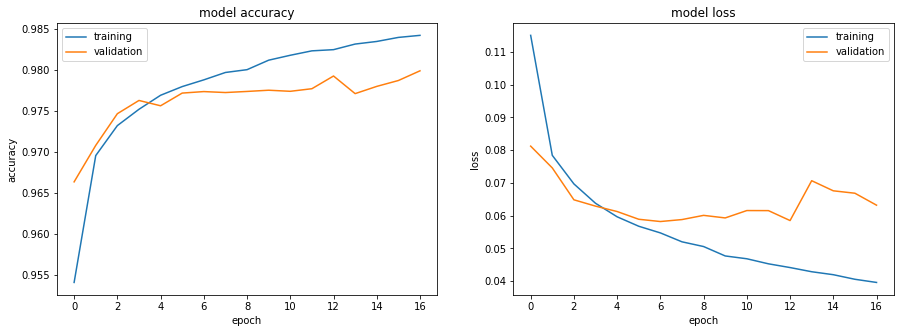

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

### 3. First Auto Encoder

#### 3.1 Reshape the training and test dataset to original shape

In [24]:
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

#### 3.2 Encoding the original data

Encoder : reduce the input dimensions and compress the input data into an encoded representation.

In [25]:
encoded = Dense(128, activation='relu')(input_img)

#### 3.3 Decode the encoded the data to be close to the original shape

Decoder : reconstruct the data from the encoded representation to be as close to the original input as possible.

In [26]:
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

#### 3.4 Auto Encoder

Autoencoder is an unsupervised artificial neural network that efficiently compress and encode data then reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

#### 3.4.1 Configures the model for training.

In [27]:
autoencoder = Model(input_img, decoded)

#Configures the model for training.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#### 3.4.2 View the structure of the deep autoencoder model

In [28]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 784)               101136    
Total params: 218,128
Trainable params: 218,128
Non-trainable params: 0
_________________________________________________________________


#### 3.4.2 Fiting the Autoencoder

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=1,
                callbacks=[es,checkpoint],
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 148us/step - loss: 0.3939 - accuracy: 0.4887 - val_loss: 0.3352 - val_accuracy: 0.4990
Epoch 2/50
60000/60000 [==============================] - 8s 139us/step - loss: 0.3226 - accuracy: 0.5037 - val_loss: 0.3163 - val_accuracy: 0.5018
Epoch 3/50
60000/60000 [==============================] - 8s 142us/step - loss: 0.3112 - accuracy: 0.5052 - val_loss: 0.3081 - val_accuracy: 0.5036
Epoch 4/50
60000/60000 [==============================] - 8s 129us/step - loss: 0.3052 - accuracy: 0.5061 - val_loss: 0.3052 - val_accuracy: 0.5035
Epoch 5/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.3010 - accuracy: 0.5066 - val_loss: 0.3013 - val_accuracy: 0.5041
Epoch 6/50
60000/60000 [==============================] - 8s 126us/step - loss: 0.2975 - accuracy: 0.5071 - val_loss: 0.2975 - val_accuracy: 0.5055
Epoch 7/50
60000/60000 [==============================] - 8s 1

#### 3.4.3 Visualization of auto encoder resutls

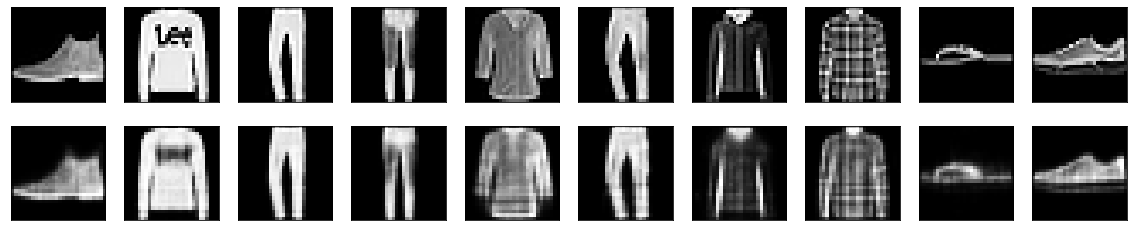

In [30]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 3.5 Encoder

#### 3.5.1 Encode the original data then summarize the data

In [31]:
encoder = Model(input_img, encoded)

#### 3.5.2 View the structure of the deep encoder model

In [32]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________


#### 3.5.2 predicting the encoder data

Generates output predictions for the x_test and x_train

In [33]:
x1_test = encoder.predict(x_test)
x1_train = encoder.predict(x_train)

### 4. Second Auto Encoder

#### 4.1 Encoding the encoded data

Encoder : reduce the input dimensions and compress the input data into an encoded representation.

In [34]:
encoded_img = Input(shape=(x1_train.shape[1],))

encoded = Dense(64, activation='relu')(encoded_img)

#### 4.2 Decode the encoded the data to be close to the original shape

Decoder : reconstruct the data from the encoded representation to be as close to the original input as possible.

In [35]:
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)

#### 4.3 Auto Encoder

Autoencoder is an unsupervised artificial neural network that efficiently compress and encode data then reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

#### 4.3.1 Configures the model for training.

In [36]:
autoencoder = Model(encoded_img,decoded)

#Configures the model for training.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#### 4.3.2 View the structure of the deep autoencoder model

In [37]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
Total params: 20,736
Trainable params: 20,736
Non-trainable params: 0
_________________________________________________________________


#### 4.3.3 Fiting the Autoencoder

In [38]:
autoencoder.fit(x1_train, x1_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=1,
                callbacks=[es,checkpoint],
                validation_data=(x1_test, x1_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 82us/step - loss: -9.2819 - accuracy: 0.2126 - val_loss: -10.4853 - val_accuracy: 0.2266
Epoch 2/50
60000/60000 [==============================] - 3s 56us/step - loss: -10.5854 - accuracy: 0.2285 - val_loss: -10.6568 - val_accuracy: 0.2317
Epoch 3/50
60000/60000 [==============================] - 5s 76us/step - loss: -10.8290 - accuracy: 0.2313 - val_loss: -11.0361 - val_accuracy: 0.2318
Epoch 4/50
60000/60000 [==============================] - 4s 73us/step - loss: -11.6708 - accuracy: 0.2332 - val_loss: -13.4386 - val_accuracy: 0.2403
Epoch 5/50
60000/60000 [==============================] - 4s 71us/step - loss: -13.4176 - accuracy: 0.2393 - val_loss: -13.4168 - val_accuracy: 0.2404
Epoch 6/50
60000/60000 [==============================] - 4s 72us/step - loss: -13.4323 - accuracy: 0.2400 - val_loss: -13.4506 - val_accuracy: 0.2394
Epoch 7/50
60000/60000 [=====================

### 4.4 Encoder

#### 4.4.1 Encode the original data then summarize the data

In [39]:
encoder = Model(encoded_img, encoded)

#### 4.4.2 View the structure of the deep encoder model

In [40]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
Total params: 8,256
Trainable params: 8,256
Non-trainable params: 0
_________________________________________________________________


#### 3.5.2 predicting the encoder data

Generates output predictions for the x_test

In [41]:
x2_test = encoder.predict(x1_test)
x2_train = encoder.predict(x1_train)

#### 4.4.5 Visualization of encoder data

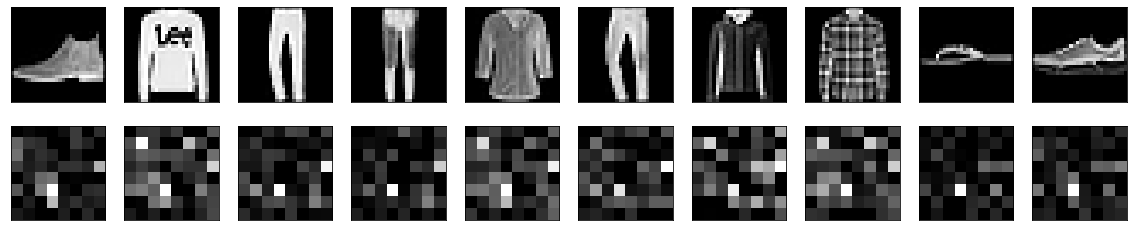

In [42]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(x2_test[i].reshape(8,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### 4.5 Classifier for encoded data

#### 4.5.1 Definition of Image Classifier Model

In [43]:
def image_classifier_model(input_size,no_classes,neurons=784, dropout_rate=0.5,
                 init_mode='uniform',optimizer='adam', learn_rate=0.01, momentum=0,
                 activation='relu'):
    input_ = Input(shape=(input_size,))
    x = Dense(neurons, kernel_initializer=init_mode,activation=activation)(input_)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(no_classes,
                   kernel_initializer=init_mode,
                   activation='softmax')(x)
    model = Model(input_, outputs)
    
    # Compile model
    # optimizer = optimizer(lr=learn_rate, momentum=momentum)
    # Optimizer     -- Adam
    # Loss function -- categorical_crossentropy
    # Metrics       -- Accuracy 
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### 4.5.2 Creating an Image Classifier Model

In [44]:
# create model
classifier = image_classifier_model(x2_test.shape[1], y_train.shape[1])

#### 4.5.3 View the structure of the image classifier model

In [45]:
# Print the model
classifier.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 784)               50960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                7850      
Total params: 58,810
Trainable params: 58,810
Non-trainable params: 0
_________________________________________________________________


#### 4.5.4 Predicting the encoder data

In [46]:
history = classifier.fit(x2_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    callbacks=[es,checkpoint],
                    validation_split=.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 5s 84us/step - loss: 0.6533 - accuracy: 0.7627 - val_loss: 0.4978 - val_accuracy: 0.8127
Epoch 2/50
54000/54000 [==============================] - 4s 74us/step - loss: 0.5222 - accuracy: 0.8049 - val_loss: 0.4541 - val_accuracy: 0.8260
Epoch 3/50
54000/54000 [==============================] - 5s 100us/step - loss: 0.4932 - accuracy: 0.8160 - val_loss: 0.4486 - val_accuracy: 0.8288
Epoch 4/50
54000/54000 [==============================] - 6s 115us/step - loss: 0.4731 - accuracy: 0.8227 - val_loss: 0.4288 - val_accuracy: 0.8350
Epoch 5/50
54000/54000 [==============================] - 6s 109us/step - loss: 0.4620 - accuracy: 0.8282 - val_loss: 0.4198 - val_accuracy: 0.8378
Epoch 6/50
54000/54000 [==============================] - 6s 114us/step - loss: 0.4478 - accuracy: 0.8325 - val_loss: 0.4082 - val_accuracy: 0.8432
Epoch 7/50
54000/54000 [==============================] - 5s 101u

#### 4.5.5 Visualization of model loss and model accuracy 

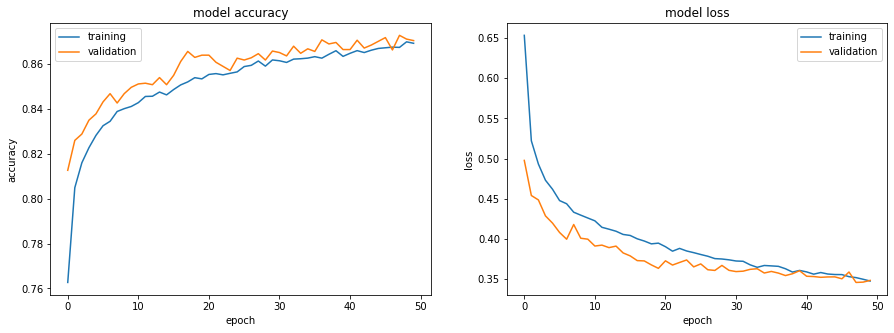

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [48]:
result = classifier.predict(x2_test)

In [49]:
loss, accuracy  = classifier.evaluate(x2_test, y_test, verbose=1)

10000/10000 [==============================] - 0s 43us/step


In [50]:
print('Test loss: %.4f' % loss)
print('Test accuracy: %.4f' % accuracy)

Test loss: 0.3796
Test accuracy: 0.8650
